In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
updateSavedModel = False

# Read in Data

In [3]:
train_dset = tf.data.experimental.load('../data/dsets/train_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets/val_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets/test_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))

In [4]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # for model evaluation
y_test = [np.where(r==1)[0][0] for r in y_test] # convert from one-hot to integer

# Model

In [6]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

num_hidden_units = 128
num_outputs = 7

sequential_model = tf.keras.Sequential()
sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True)))
sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units)))
sequential_model.add(tf.keras.layers.Dense(num_outputs,activation='softmax'))

input_layer = tf.keras.Input(shape=(300, 171)) 
model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 171)]        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 7)                 703239    
Total params: 703,239
Trainable params: 703,239
Non-trainable params: 0
_________________________________________________________________


In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50,restore_best_weights=True)

history = model.fit(train_dset,epochs=100,validation_data = val_dset,callbacks=[es])
# TODO definitely needs more epochs (see loss curve below)

Epoch 1/100
100/100 [==============================] - 29s 288ms/step - loss: 1.9760 - accuracy: 0.1650 - val_loss: 1.9688 - val_accuracy: 0.1400
Epoch 2/100
100/100 [==============================] - 24s 238ms/step - loss: 1.9479 - accuracy: 0.1594 - val_loss: 1.9631 - val_accuracy: 0.1400
Epoch 3/100
100/100 [==============================] - 22s 220ms/step - loss: 1.9405 - accuracy: 0.1581 - val_loss: 1.9493 - val_accuracy: 0.1400
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 1.9260 - accuracy: 0.1706 - val_loss: 1.9536 - val_accuracy: 0.1500
Epoch 5/100
100/100 [==============================] - 23s 233ms/step - loss: 1.9626 - accuracy: 0.1600 - val_loss: 1.9958 - val_accuracy: 0.1400
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 1.9206 - accuracy: 0.1894 - val_loss: 1.9750 - val_accuracy: 0.1400
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 1.9429 - accuracy: 0.1612 - val_loss: 1.9520 -

Epoch 57/100
100/100 [==============================] - 24s 242ms/step - loss: 1.2694 - accuracy: 0.5044 - val_loss: 1.3972 - val_accuracy: 0.4400
Epoch 58/100
100/100 [==============================] - 24s 241ms/step - loss: 1.2122 - accuracy: 0.5412 - val_loss: 1.5242 - val_accuracy: 0.3950
Epoch 59/100
100/100 [==============================] - 24s 241ms/step - loss: 1.2109 - accuracy: 0.5419 - val_loss: 1.3520 - val_accuracy: 0.4700
Epoch 60/100
100/100 [==============================] - 24s 241ms/step - loss: 1.2262 - accuracy: 0.5356 - val_loss: 1.3569 - val_accuracy: 0.4900
Epoch 61/100
100/100 [==============================] - 24s 241ms/step - loss: 1.1466 - accuracy: 0.5619 - val_loss: 1.3515 - val_accuracy: 0.5250
Epoch 62/100
100/100 [==============================] - 24s 241ms/step - loss: 1.1260 - accuracy: 0.5806 - val_loss: 1.3580 - val_accuracy: 0.5100
Epoch 63/100
100/100 [==============================] - 24s 241ms/step - loss: 1.0859 - accuracy: 0.5888 - val_loss: 1

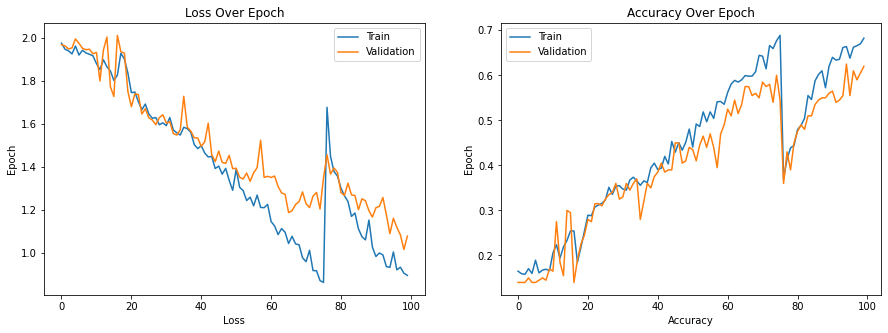

In [9]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

# TODO definitely something sketchy with this loss, could be a learning rate thing?

In [10]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 1s 87ms/step - loss: 1.1223 - accuracy: 0.5800
Test accuracy: 0.580


In [11]:
# save model
if updateSavedModel:
    model.save("trained-models/model_lstm")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained-models/model_lstm/assets


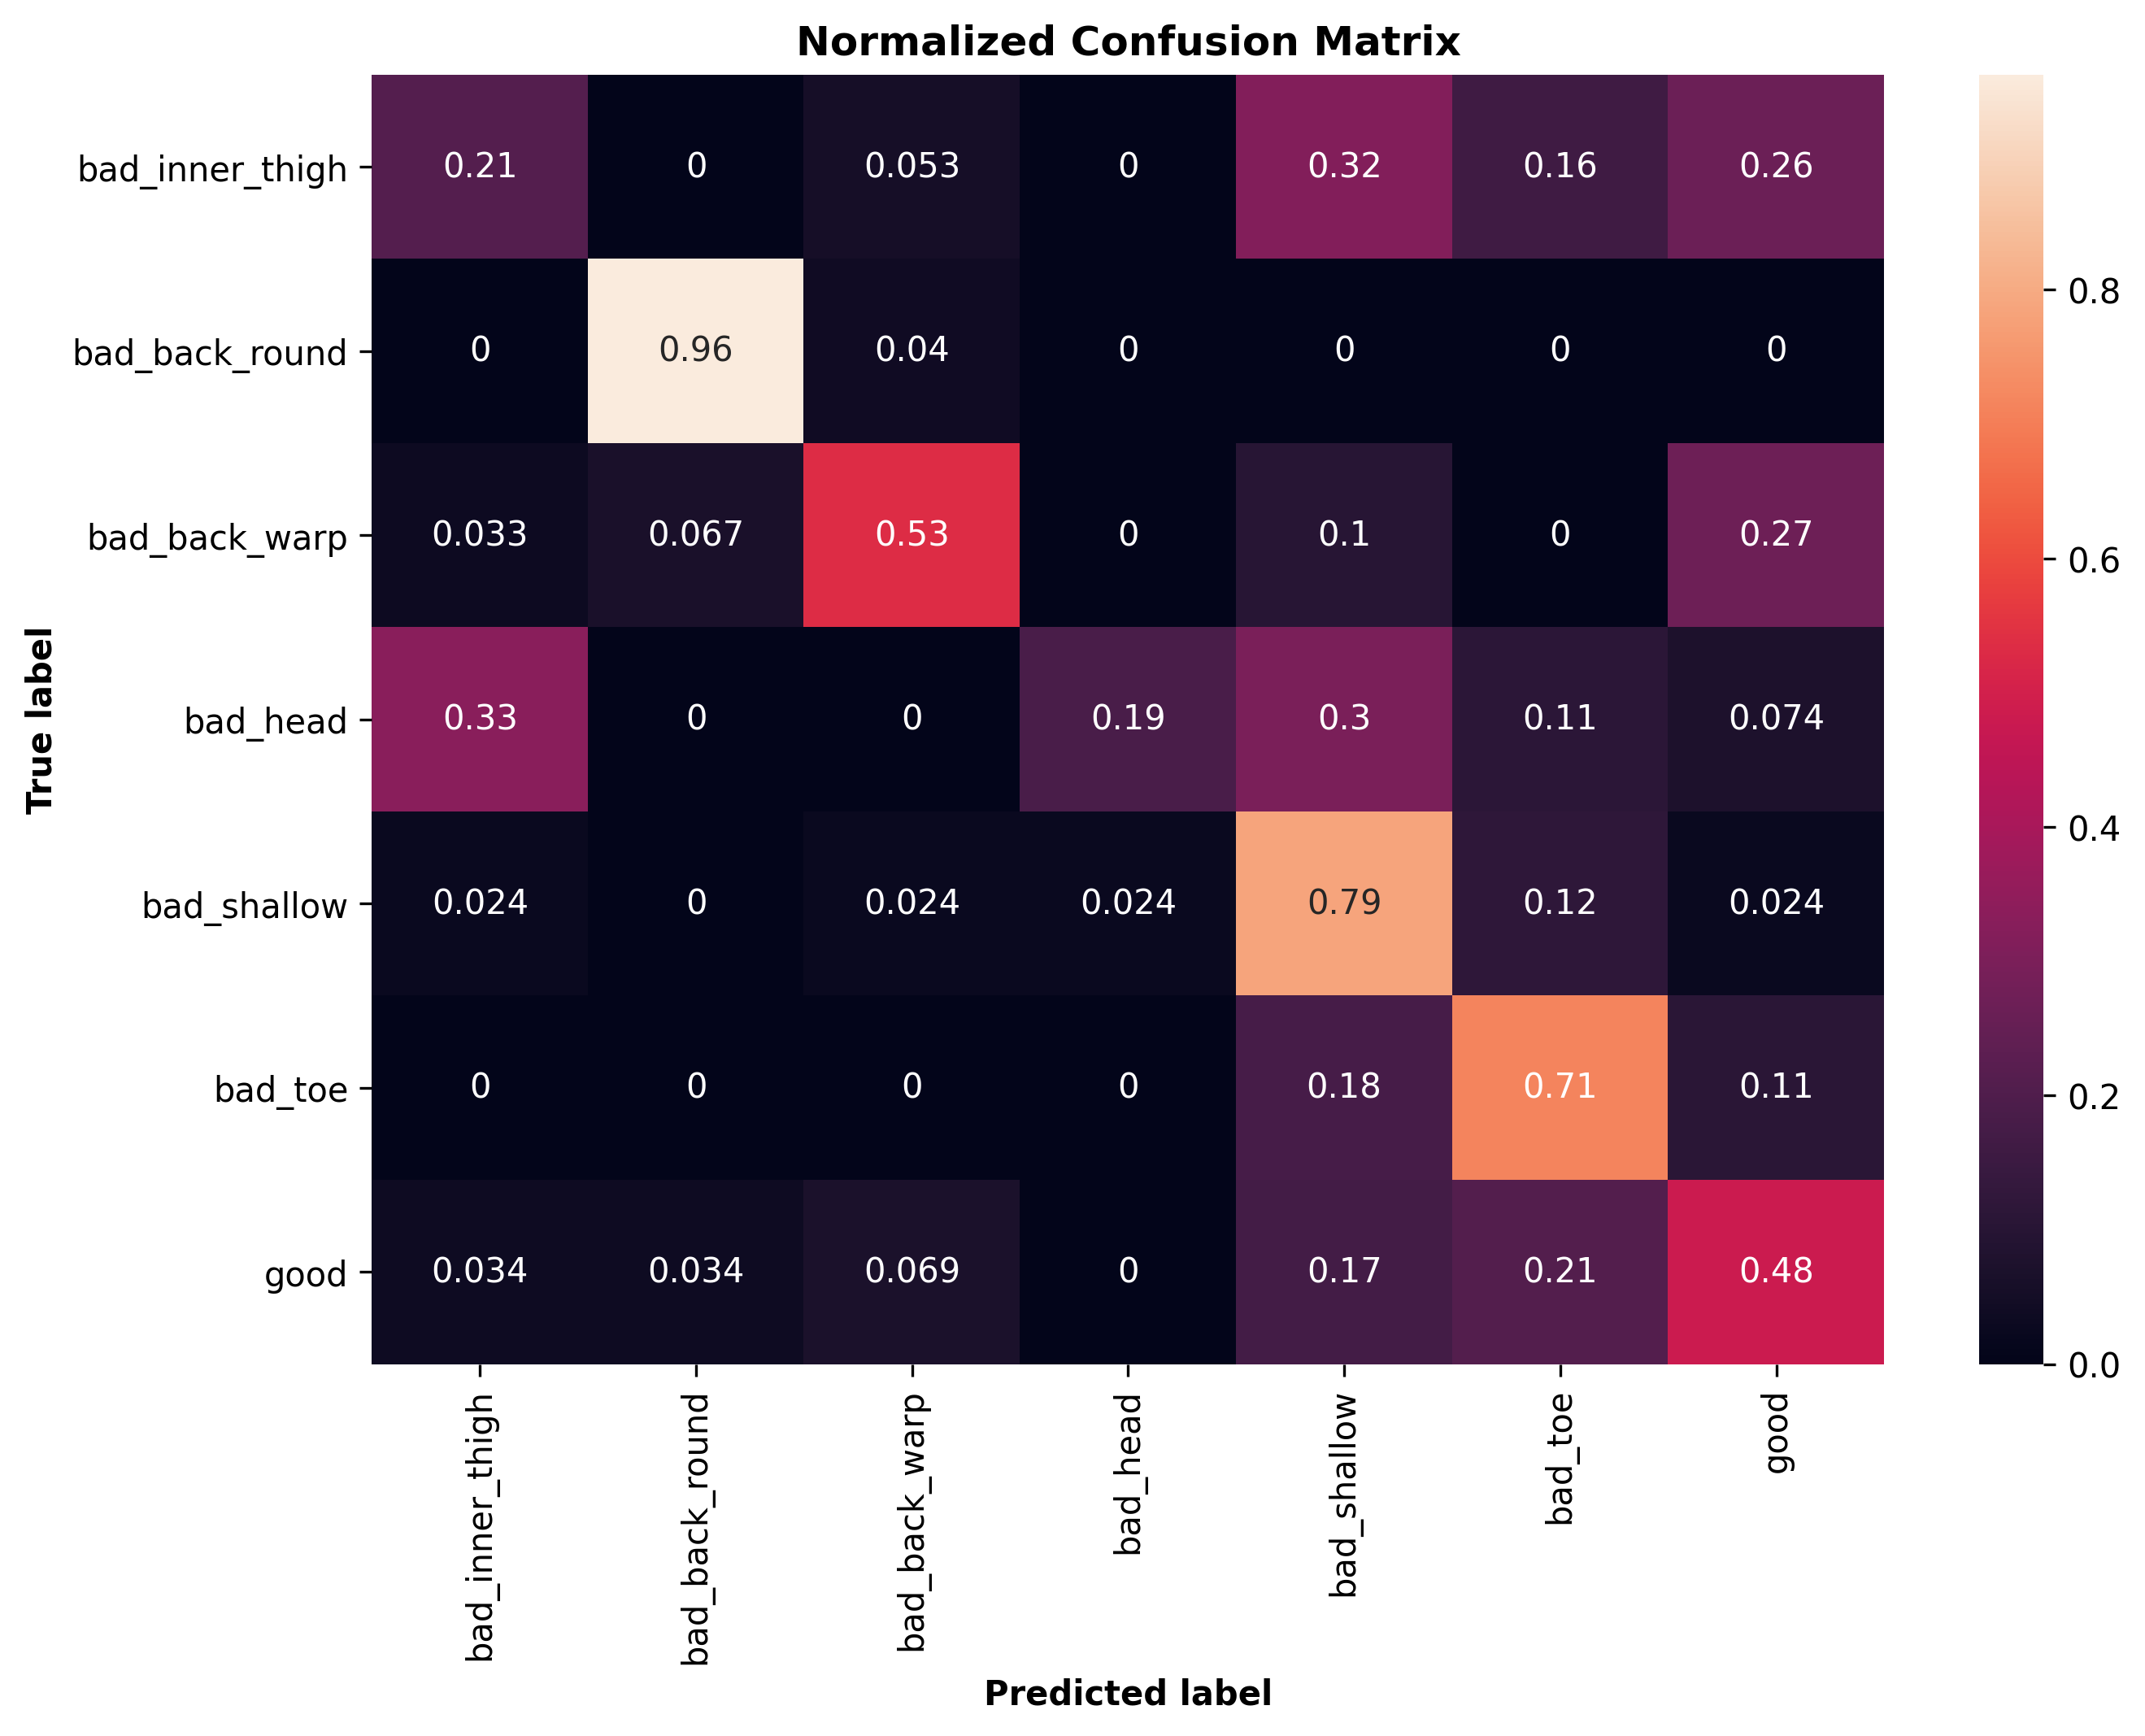


Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.61
Macro Recall: 0.55
Macro F1-score: 0.54

Weighted Precision: 0.61
Weighted Recall: 0.58
Weighted F1-score: 0.56

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.25      0.21      0.23        19
 bad_back_round       0.89      0.96      0.92        25
  bad_back_warp       0.76      0.53      0.63        30
       bad_head       0.83      0.19      0.30        27
    bad_shallow       0.55      0.79      0.65        42
        bad_toe       0.54      0.71      0.62        28
           good       0.42      0.48      0.45        29

       accuracy                           0.58       200
      macro avg       0.61      0.55      0.54       200
   weighted avg       0.61      0.58      0.56       200

Cohen Kappa Statistic



0.5017202515126349

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)